In [28]:
import pickle
import pandas as pd
import seaborn as sns
from autogluon.tabular import TabularPredictor

## Loading Data Sets and Stuff
This requires running *'../../Create_Tune_Models.automatic_baseline.ipynb'* first.

In [ ]:
train_df = pd.read_csv('../../Data/original/train_2025.csv')
test_df = pd.read_csv('../../Data/original/test_2025.csv')

predictor = TabularPredictor.load('../../AutogluonModels/ag-20250426_135506/')

# Load processed features
with open('../../AutogluonModels/ag-20250426_135506/utils/data/X.pkl', 'rb') as f:
    X_processed = pickle.load(f)

# Load processed labels
with open('../../AutogluonModels/ag-20250426_135506/utils/data/y.pkl', 'rb') as f:
    y_processed = pickle.load(f)

1. Preliminary Cleaning: One-Hot Encoding, Processing DateTime

In [37]:
# === Process test set features ===
df_test_raw = test_df.drop(columns=['claim_number'])  # Remove ID before transformation
df_test_processed = predictor.transform_features(df_test_raw)
# df_train_processed = X_processed

df_test_processed['claim_number'] = test_df['claim_number'].values  # Add ID back

# === Add 'fraud' label and 'claim_number' back to training set ===
df_train_processed = X_processed.copy()
df_train_processed['fraud'] = y_processed.values
df_train_processed['claim_number'] = train_df['claim_number'].values

# === Reset index for both sets ===
df_train_processed.reset_index(drop=True, inplace=True)
df_test_processed.reset_index(drop=True, inplace=True)

In [24]:
df_train_processed

,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,zip_code,past_num_of_claims,...,claim_day_of_week,accident_site,channel,vehicle_category,vehicle_color,claim_date,claim_date.year,claim_date.month,claim_date.day,claim_date.dayofweek
0,58,1,1.0,83,117115,1,0,0,85027,0,...,4,1,0,2,3,1427932800000000000,2015,4,2,3
1,37,0,0.0,76,57945,1,0,1,85004,14,...,1,2,0,1,1,1450051200000000000,2015,12,14,0
2,33,0,0.0,82,79027,1,0,1,85027,0,...,2,1,0,0,0,1455321600000000000,2016,2,13,5
3,43,0,0.0,40,98544,1,0,0,15028,0,...,1,2,0,1,6,1443398400000000000,2015,9,28,0
4,43,0,1.0,84,62619,1,1,0,20148,9,...,4,2,0,2,1,1454544000000000000,2016,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,43,0,1.0,65,97505,1,0,0,50042,11,...,6,1,0,2,6,1422403200000000000,2015,1,28,2
17996,33,0,0.0,65,81642,1,1,0,85077,13,...,5,1,0,1,2,1430179200000000000,2015,4,28,1
17997,39,1,0.0,84,123385,0,1,0,85034,16,...,5,1,0,0,2,1465862400000000000,2016,6,14,1
17998,49,0,0.0,89,91848,1,0,1,20113,16,...,0,1,0,0,0,1481846400000000000,2016,12,16,4


<Axes: xlabel='dow_difference', ylabel='Count'>

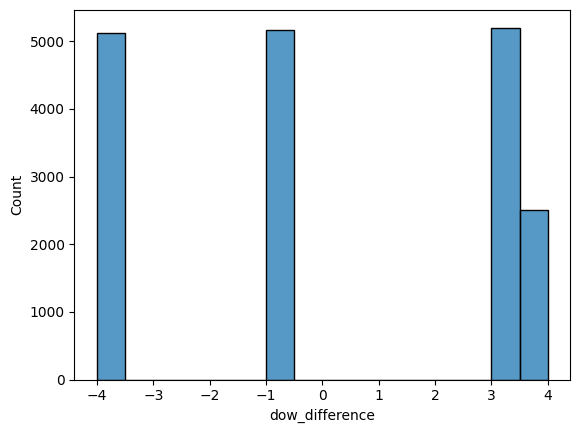

In [30]:
df_train_processed['dow_difference'] = (
    df_train_processed['claim_date.dayofweek'].astype(int) - df_train_processed['claim_day_of_week'].astype(int)
)
sns.histplot(df_train_processed['dow_difference'])

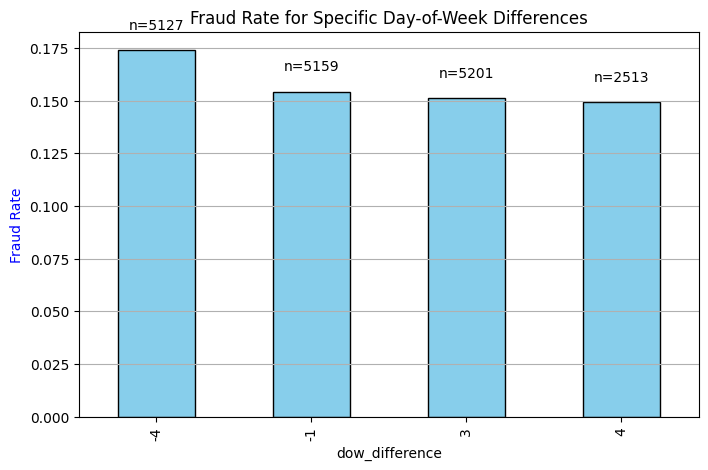

In [39]:
# Focus only on the dow_difference values you care about
interesting_dow_diffs = [-1, -4, 3, 4]

# Filter to just those rows
df_focus = df_train_processed[df_train_processed['dow_difference'].isin(interesting_dow_diffs)]

# Group by dow_difference and calculate fraud rate
fraud_rates_by_dow_diff = df_focus.groupby('dow_difference')['fraud'].mean().sort_index()

# Also count how many samples per group
sample_counts = df_focus['dow_difference'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8, 5))

# Fraud rate plot
fraud_rates_by_dow_diff.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax1)
ax1.set_ylabel('Fraud Rate', color='blue')
ax1.set_xlabel('dow_difference')
ax1.set_title('Fraud Rate for Specific Day-of-Week Differences')
ax1.grid(axis='y')

# Show sample counts on top of bars
for idx, value in enumerate(fraud_rates_by_dow_diff):
    count = sample_counts.iloc[idx]
    ax1.text(idx, value + 0.01, f'n={count}', ha='center', color='black')

plt.show()


In [ ]:
df_train_processed['claim_date.dayofweek'] - df_train_processed['claim_day_of_week']

TypeError: Object with dtype category cannot perform the numpy op subtract